In [82]:
import logging
import pandas as pd
import numpy as np
import jieba
from gensim.models import word2vec

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

## w2v

In [149]:
# Loading dataset
train = pd.read_csv('train.csv')
train
val = pd.read_csv('validation.csv')
val

,content,Label
0,我有個國小認識的好朋友，上了大學後常常會跟我訴苦，大多是關於人際關係的他個性比較內向，不容易...,0
1,(第一人稱視角，)媽媽跟爸爸從我出生就感情不好 所以國小時離婚了我喜歡媽媽 不喜歡爸爸但我們...,1
2,我的前任在自殺前一周突然幫我慶生，一天前找我出門玩，再一聲不吭的自我了斷，給我很大的陰影。現...,0
3,身為一個亞斯伯格症的人看到這則新聞還蠻難過的首先我可以理解家長看到自己小孩無緣無故被攻擊而想...,0
4,真的很長，防雷。26個年頭來，經歷了大小事情。媽媽在國小開始因為經濟不景氣、收店的壓力、被朋...,0
...,...,...
249,我是1995年出生，我妹則是1999年出生，過去這兩年我們家歷經了非常嚴重的衝突。我和我妹都...,0
250,我有個水瓶男好朋友他會跟我說相處自在點他都是想怎樣就怎樣很隨性我也有點這樣所以我們才能成為好...,0
251,如題小時候我真的是活在陰影下...從我有印象第一次被打的那時候開始講吧！那時我才國中一年級 ...,0
252,如標題我現在已經滿20了，我家在北部但是在外縣市讀書當初高中填志願的時候就是為了逃離我媽才把...,0


In [150]:
## 取200筆非自殺
train_neg = train[train["Label"] == 0].iloc[:200]
train_pos = train[train["Label"] == 1]
train = pd.concat([train_neg,train_pos])
train = train.reset_index(drop=True)
train

,Content,Label
0,仙草加蜂蜜好好吃！等下再去市場買一塊大仙草~吃吃吃好像把今天的熱量扣打吃完了-----Sen...,0
1,啊啊啊 邁入老女人的里程碑了今天本來想請假的但被同事搶先了然後從禮拜六開始爸爸媽媽就滿滿的情...,0
2,今天同事提出，覺得我有點過度依賴男友了不是第一個人說出這個問題其實早在交往的一開始我自己就察...,0
3,開始停速悅的這幾天我還是會吃安立平總覺得現在除了心悸手抖頭很重以外一直還有個在耳邊敲打小軍鼓...,0
4,我覺得有些善意的謊言是可以說的就是那些不會被揭穿的但有一些是一定會被揭穿「你狀態不好的時侯可...,0
...,...,...
298,很想一走了之。從人生這場遊戲登出。去年以前，厭食了6年去年開始暴食。或許我恨的是自己所以什麼...,1
299,要嘛給我愛，要嘛給我錢，要嘛給我滾。其實你連當炮友的資格都沒有，憑什麼跟我談戀愛？無法給我愛...,1
300,以為可以好一陣子不用上來發文了生命又再次賞我好一大巴掌我真的真的真的很努力很努力了我為甚麼總...,1
301,從四年前，一直都有失眠的小問題，但都是以作息不正常來解套自己的想法。前年二月到六月，我的狀況...,1


In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# jieba custom setting.
jieba.set_dictionary('jieba_dict/dict.txt.big')

# load stopwords set
stopword_set = set()
with open('jieba_dict/stopwords.txt','r', encoding='utf-8') as stopwords:
    for stopword in stopwords:
        stopword_set.add(stopword.strip(' \n'))

In [5]:
def jieba_tokenizer(content):
    if str(content)=='nan':
        return ''
    words = jieba.cut(content.replace(' ',''))
    return [word for word in words if word not in stopword_set]

In [151]:
train['tokenized'] = list(train.loc[:, 'Content'].apply(jieba_tokenizer))
val['tokenized'] = list(val.loc[:, 'content'].apply(jieba_tokenizer))
train['tokenized']
val['tokenized']

0      [國小, 認識, 朋友, 大學, 常常, 會, 訴苦, 大多, 關於, 人際關係, 個性, ...
1      [第一人稱, 視角, 媽媽, 爸爸, 出生, 感情, 不好, 所以, 國, 小時, 離婚, ...
2      [前任, 自殺, 前, 一周, 突然, 幫, 慶生, 一天, 前, 找, 出門, 玩, 一聲...
3      [身為, 亞, 斯伯格, 症, 看到, 這則, 新聞, 還蠻, 難過, 首先, 可以, 理解...
4      [真的, 很長, 防雷, 26, 年頭, 經歷, 大小, 事情, 媽媽, 國小, 開始, 因...
                             ...                        
249    [1995, 年, 出生, 妹則, 1999, 年, 出生, 過去, 兩年, 家, 歷經, ...
250    [水瓶, 男好, 朋友, 他會, 說, 相處, 自在點, 想, 怎樣, 怎樣, 隨性, 有點...
251    [題, 小時候, 真的, 活, 陰影, ..., 印象, 第一次, 時候, 開始, 講吧, ...
252    [標題, 現在, 已經, 滿, 20, 我家, 北部, 但是, 在外, 縣市, 讀書, 當初...
253    [出事, 才, 徹底, 知道, 就算, 抑鬱, 憂鬱, 還是, 可能, 自殺, 念頭, 只是...
Name: tokenized, Length: 254, dtype: object

In [7]:
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load("w2v_model.wv", mmap='r')

2020-11-03 13:23:48,962 : INFO : loading Word2VecKeyedVectors object from w2v_model.wv
2020-11-03 13:23:51,475 : INFO : loading vectors from w2v_model.wv.vectors.npy with mmap=r
2020-11-03 13:23:51,478 : INFO : setting ignored attribute vectors_norm to None
2020-11-03 13:23:51,478 : INFO : loaded w2v_model.wv


In [165]:
# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors # If use pytorch add torch.from_numpy()
vocab_size, embedding_size = w2v_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

Vocabulary Size: 883958 - Embedding Dim: 250


/home/ubuntu-gpu/anaconda3/envs/trainEnv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [152]:
import copy
train['word_vec'] = copy.deepcopy(train['tokenized'])
train
val['word_vec'] = copy.deepcopy(val['tokenized'])
val

,content,Label,tokenized,word_vec
0,我有個國小認識的好朋友，上了大學後常常會跟我訴苦，大多是關於人際關係的他個性比較內向，不容易...,0,"[國小, 認識, 朋友, 大學, 常常, 會, 訴苦, 大多, 關於, 人際關係, 個性, ...","[國小, 認識, 朋友, 大學, 常常, 會, 訴苦, 大多, 關於, 人際關係, 個性, ..."
1,(第一人稱視角，)媽媽跟爸爸從我出生就感情不好 所以國小時離婚了我喜歡媽媽 不喜歡爸爸但我們...,1,"[第一人稱, 視角, 媽媽, 爸爸, 出生, 感情, 不好, 所以, 國, 小時, 離婚, ...","[第一人稱, 視角, 媽媽, 爸爸, 出生, 感情, 不好, 所以, 國, 小時, 離婚, ..."
2,我的前任在自殺前一周突然幫我慶生，一天前找我出門玩，再一聲不吭的自我了斷，給我很大的陰影。現...,0,"[前任, 自殺, 前, 一周, 突然, 幫, 慶生, 一天, 前, 找, 出門, 玩, 一聲...","[前任, 自殺, 前, 一周, 突然, 幫, 慶生, 一天, 前, 找, 出門, 玩, 一聲..."
3,身為一個亞斯伯格症的人看到這則新聞還蠻難過的首先我可以理解家長看到自己小孩無緣無故被攻擊而想...,0,"[身為, 亞, 斯伯格, 症, 看到, 這則, 新聞, 還蠻, 難過, 首先, 可以, 理解...","[身為, 亞, 斯伯格, 症, 看到, 這則, 新聞, 還蠻, 難過, 首先, 可以, 理解..."
4,真的很長，防雷。26個年頭來，經歷了大小事情。媽媽在國小開始因為經濟不景氣、收店的壓力、被朋...,0,"[真的, 很長, 防雷, 26, 年頭, 經歷, 大小, 事情, 媽媽, 國小, 開始, 因...","[真的, 很長, 防雷, 26, 年頭, 經歷, 大小, 事情, 媽媽, 國小, 開始, 因..."
...,...,...,...,...
249,我是1995年出生，我妹則是1999年出生，過去這兩年我們家歷經了非常嚴重的衝突。我和我妹都...,0,"[1995, 年, 出生, 妹則, 1999, 年, 出生, 過去, 兩年, 家, 歷經, ...","[1995, 年, 出生, 妹則, 1999, 年, 出生, 過去, 兩年, 家, 歷經, ..."
250,我有個水瓶男好朋友他會跟我說相處自在點他都是想怎樣就怎樣很隨性我也有點這樣所以我們才能成為好...,0,"[水瓶, 男好, 朋友, 他會, 說, 相處, 自在點, 想, 怎樣, 怎樣, 隨性, 有點...","[水瓶, 男好, 朋友, 他會, 說, 相處, 自在點, 想, 怎樣, 怎樣, 隨性, 有點..."
251,如題小時候我真的是活在陰影下...從我有印象第一次被打的那時候開始講吧！那時我才國中一年級 ...,0,"[題, 小時候, 真的, 活, 陰影, ..., 印象, 第一次, 時候, 開始, 講吧, ...","[題, 小時候, 真的, 活, 陰影, ..., 印象, 第一次, 時候, 開始, 講吧, ..."
252,如標題我現在已經滿20了，我家在北部但是在外縣市讀書當初高中填志願的時候就是為了逃離我媽才把...,0,"[標題, 現在, 已經, 滿, 20, 我家, 北部, 但是, 在外, 縣市, 讀書, 當初...","[標題, 現在, 已經, 滿, 20, 我家, 北部, 但是, 在外, 縣市, 讀書, 當初..."


In [153]:
for i in range(len(train['word_vec'])):
    for j in range(len(train['word_vec'][i])):
        train['word_vec'][i][j] = word2token(train['word_vec'][i][j])
        
for i in range(len(val['word_vec'])):
    for j in range(len(val['word_vec'][i])):
        val['word_vec'][i][j] = word2token(val['word_vec'][i][j])

/home/ubuntu-gpu/anaconda3/envs/trainEnv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


# LSTM

## Pytorch

In [ ]:
def pad_samples(features, maxlen=250, PAD=0): #截長補短 讓長度一致，這裡固定文章長度為maxlen=250
    padded_features = []
    for feature in features:
        if len(feature) >= maxlen:
            padded_feature = feature[:maxlen]
        else:
            padded_feature = feature
            while(len(padded_feature) < maxlen):
                padded_feature.append(PAD)
        padded_features.append(padded_feature)
    return padded_features

In [ ]:
train_features = torch.tensor(pad_samples(train['word_vec']))
vali_features = torch.tensor(pad_samples(vali['word_vec']))
vali_features

In [ ]:
# label_vec_to_torch.tensor
train_labels = torch.tensor(train['Label'])
vali_labels = torch.tensor(vali['Label'])
vali_labels

In [ ]:
### create pytorch dataloader ###
batch_size = 64
train_set = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)

vali_set = torch.utils.data.TensorDataset(vali_features, vali_labels)
vali_iter = torch.utils.data.DataLoader(vali_set, batch_size=batch_size,shuffle=True)

In [ ]:
### build model ###
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 bidirectional, weight, labels, **kwargs):
        super(RNN, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.embedding.weight.requires_grad = False
        self.encoder = nn.LSTM(input_size=embed_size, hidden_size=self.num_hiddens,
                               num_layers=num_layers, bidirectional=self.bidirectional,
                               dropout=0.3)

        if self.bidirectional:
            self.linear1 = nn.Linear(num_hiddens * 4, labels)
        else:
            self.linear1 = nn.Linear(num_hiddens * 2, labels)



    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        states, hidden = self.encoder(embeddings.permute([1, 0, 2]))
        encoding = torch.cat([states[0], states[-1]], dim=1) #if it's bidirectional, choose first and last output
        outputs = self.linear1(encoding)

        return outputs

num_epochs = 10
num_hiddens = 100
num_layers = 2
bidirectional = True
labels = 2
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
net = RNN(vocab_size=(vocab_size+1), embed_size=embedding_size,
                   num_hiddens=num_hiddens, num_layers=num_layers,
                   bidirectional=bidirectional, weight=w2v_weights,
                   labels=labels)

print(net)

In [ ]:
net.to(device)
loss_function = nn.CrossEntropyLoss() # ~ nn.LogSoftmax()+nn.NLLLoss()
optimizer = optim.Adam(net.parameters())

def train(net,num_epochs,loss_function,optimizer,train_iter,val_iter):
    for epoch in range(num_epochs):
        start = time.time()
        train_loss, val_losses = 0, 0
        train_acc, val_acc = 0, 0
        n, m = 0, 0
        net.train()
        for feature, label in train_iter:
            n += 1
            optimizer.zero_grad()
            feature = Variable(feature.to(device))
            label = Variable(label.to(device))

            score = net(feature)
            loss = loss_function(score, label)
            loss.backward()
            optimizer.step()
            train_acc += accuracy_score(torch.argmax(score.cpu().data,dim=1), label.cpu())
            train_loss += loss

        with torch.no_grad():
            net.eval()
            for val_feature, val_label in val_iter:
                m += 1
                val_feature = val_feature.to(device)
                val_label = val_label.to(device)
                val_score = net(val_feature)
                val_loss = loss_function(val_score, val_label)
                val_acc += accuracy_score(torch.argmax(val_score.cpu().data,dim=1), val_label.cpu())
                val_losses += val_loss

        runtime = time.time() - start
        print('epoch: %d, train loss: %.4f, train acc: %.2f, val loss: %.4f, val acc: %.2f, time: %.2f' %
              (epoch, train_loss.data/n, train_acc/n, val_losses.data/m, val_acc/m, runtime))

    #save final model
    state = {
            'epoch': epoch,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict()
            }
    torch.save(state, os.path.join(model_save_path,'last_model.pt'))


def predict(net,test_iter):
    #state = torch.load(os.path.join(cwd,'checkpoint','epoch10_maxlen300_embed200.pt'),map_location=torch.device('cpu'))
    #net.load_state_dict(state['state_dict'])
    pred_list = []
    true_list = []
    softmax = nn.Softmax(dim=1)
    with torch.no_grad():
        net.eval()
        for batch,label in test_iter:
            output = net(batch.to(device))
            pred_list.extend(torch.argmax(softmax(output),dim=1).cpu().numpy())
            true_list.extend(label.cpu().numpy())

    acc = accuracy_score(pred_list, true_list)
    print('test acc: %f'%acc)

    return acc,pred_list,true_list


print('start to train...')
train(net,num_epochs,loss_function,optimizer,train_iter,vali_iter)

print('start to predict test set...')
acc,pred_list,true_list = predict(net,test_iter)

print('Done')

# Keras

In [154]:
x_train = train['word_vec']
x_train
x_val = val['word_vec']
x_val

0      [31448, 2091, 704, 40, 3049, 10, 88999, 2712, ...
1      [12122, 11903, 1624, 2511, 652, 2717, 6851, 26...
2      [5152, 2514, 28, 294496, 1970, 2977, 46777, 16...
3      [5376, 1741, 31671, 6648, 1562, 66473, 436, 25...
4      [2734, 15627, 236587, 0, 52267, 923, 2042, 226...
                             ...                        
249    [0, 0, 652, 757133, 0, 0, 652, 842, 1912, 396,...
250    [48502, 569899, 704, 16088, 113, 10422, 0, 710...
251    [9290, 6590, 2734, 7689, 10675, 0, 5233, 894, ...
252    [984, 327, 228, 3129, 0, 9668, 1153, 176, 1128...
253    [41770, 215, 4361, 869, 7624, 30254, 11988, 80...
Name: word_vec, Length: 254, dtype: object

In [155]:
# label_vec
y_train = np.asarray(train['Label'])
y_val = np.asarray(val['Label'])
y_val

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [26]:
# 建立 LSTM 架構
from keras import Input
from keras.layers import Embedding, LSTM, concatenate, Dense, Bidirectional
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [156]:
# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 250

input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

In [157]:
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)
x_val = pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)
len(x_val[0])

250

In [176]:
del model

In [178]:
# Keras Embedding layer with Word2Vec weights initialization
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

model.add(Bidirectional(LSTM(125)))
model.add(Dense(4, input_dim=2, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(units=2, activation='sigmoid'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, batch_size=64,
                    validation_data=(x_val, y_val), verbose=1)

Train on 303 samples, validate on 254 samples
Epoch 1/5
303/303 [==============================] - 18s 59ms/step - loss: 0.6959 - accuracy: 0.5578 - val_loss: 0.6880 - val_accuracy: 0.8740
Epoch 2/5
303/303 [==============================] - 10s 34ms/step - loss: 0.6900 - accuracy: 0.6601 - val_loss: 0.6800 - val_accuracy: 0.8740
Epoch 3/5
303/303 [==============================] - 10s 34ms/step - loss: 0.6854 - accuracy: 0.6601 - val_loss: 0.6640 - val_accuracy: 0.8740
Epoch 4/5
303/303 [==============================] - 10s 34ms/step - loss: 0.6780 - accuracy: 0.6601 - val_loss: 0.6279 - val_accuracy: 0.8740
Epoch 5/5
303/303 [==============================] - 10s 34ms/step - loss: 0.6613 - accuracy: 0.6601 - val_loss: 0.5727 - val_accuracy: 0.8740


In [179]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 250, 250)          220989500 
_________________________________________________________________
bidirectional_9 (Bidirection (None, 250)               376000    
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 1004      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 10        
Total params: 221,366,534
Trainable params: 377,034
Non-trainable params: 220,989,500
_________________________________________________________________


In [164]:
model.save('lstm_model.h5')

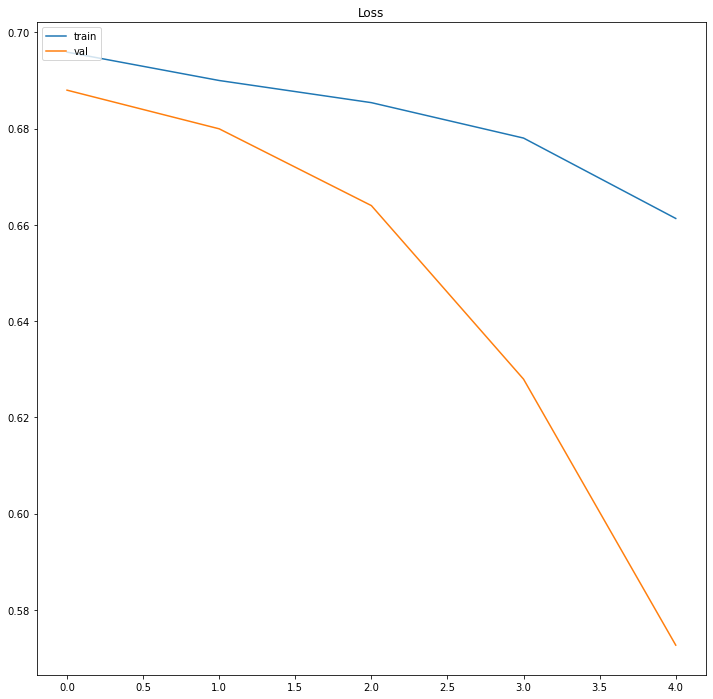

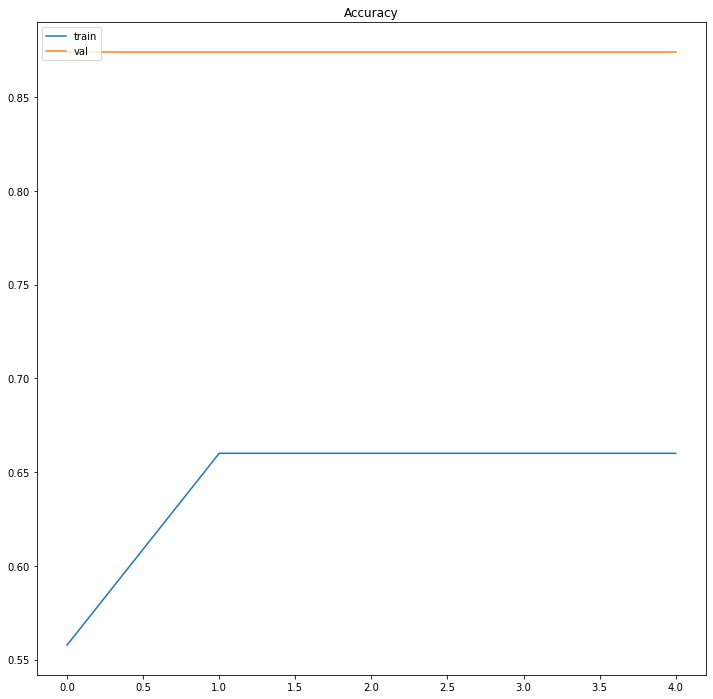

In [180]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()